# Constructing the Method of Moment Matrix
# by Allowing Automatic Differentiation (ForwardDiff, Zygote, GTPSA or Otherwise)
# to Operate Twice on Quadrature  (QuadGK, HCubature or Otherwise) Output 

## Import Packages

In [6]:
using ForwardDiff
using QuadGK
using HCubature 
using StaticArrays 
using LinearAlgebra
using BenchmarkTools
using Plots 

In [32]:
const Point3D = SVector{3,Float64};

### Sandbox 

In [7]:
pi

π = 3.1415926535897...

In [73]:
# integrand(th) = cos(th) / (1 - cos(th))^(1.5)
# integrand(th) = 1 / (1 - cos(th))^(2)
integrand(r) = 1 / (1+r[1]^2-2*r[1]*cos(r[2]))^(1.5)

integrand (generic function with 1 method)

In [66]:
rd = Point3D(1.5, pi/4, 0)   
integrand(rd)

6.332865280216563

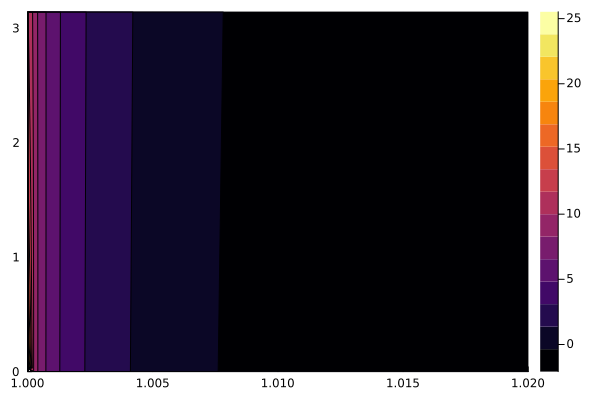

In [67]:
Nr = 100; rmesh = range(1, stop=1.02,length=Nr)
Nt = 100; tmesh = range(0, stop=π,length=Nt)
result = zeros(Nr,Nt)
for (i,ri) in enumerate(rmesh)
    for (j,tj) in enumerate(tmesh)
        rd = Point3D(ri,tj,0)
        result[i,j] = integrand(rd)
    end 
end
contourf(rmesh, tmesh, log.(result)) 

In [75]:
# valintegrand = quadgk(th -> integrand(th), pi/6, pi) 
hcubature(r -> integrand(r)*r[1]^2*cos(r[2])*cos(r[3]), (1,0,0), (1.1,pi/2,pi/2))

(Inf, NaN)

## To do: 
Stress explicit and explicit constructions. 

## Section 1: Introduction 
<b>Motivation</b> We wish to generate the Method of Moment (MoM) matrix as the linear transformation matrix (sensitivity matrix, input-output matrix) mapping magnetization vector $\vec{M}(\vec{x})$ to the magnetic flux vector $\vec{B}(\vec{x})$ after spatial discretization (first discretize, then differentiate) (need to include magnetic field $\vec{H}(\vec{x})$). The above ideas are borrowed from non-linear FEM analysis is which the Jacobian is formed as the derivative of the residual vector w.r.t. the state vector. More details of both steps will be outlined below.  

<b>Problem Formulation</b> Assume a 3D computational domain $\vec{x} \in \Omega$ with a subset $\Omega_M$ on with the magnetic sources are defined. In a continuous setting (i.e. prior to spatial discretization), the magnetic vector potential $\vec{A}(\vec{x})$ is a function of the magnetization vector $\vec{M}(\vec{x})$. A [Biot-Savart](https://en.wikipedia.org/wiki/Biot–Savart_law) type relation yields that 
$$\vec{A}(\vec{x}) = \frac{\mu_0}{4 \pi} \int_{\Omega_m} 
                \frac{\vec{M}(\vec{x}') \times (\vec{x}-\vec{x}')}{|\vec{x}-\vec{x}'|^3} \, d\vec{x}' \, = \int_{\Omega_m} \vec{M}(\vec{x}') \times K(\vec{x}, \vec{x}') \, d\vec{x}' $$, where the kernel $K(\vec{x}, \vec{x}')$ is given by 
$$K(\vec{x},\vec{x}') = \frac{\mu_0}{4 \pi}  
                \frac{(\vec{x}-\vec{x}')}{\|\vec{x}-\vec{x}'\|^3} = 
                \frac{\mu_0}{4 \pi} \nabla \frac{1}{\|\vec{x}-\vec{x}'\|} \, . $$              The magnetic flux $\vec{B}(\vec{x})$ is then obtained via 
$$ \vec{B}(\vec{x}) = \nabla \times \vec{A}(\vec{x}) \, . $$
The magnetic field $\vec{H}(\vec{x})$ can be obtain as $\mu \, \vec{B}(\vec{x})$ in the ferromagnetic region and from $\mu \, \vec{B}(\vec{x}) + \vec{M}(\vec{x})$ in the magnetic region.  

<b>Spatial Discretization</b> A mesh $\Omega^h$ on $\Omega$ with $N$ nodes is defined. The numerical approximation to vector $\vec{M}(\vec{x})$ is expressed as a linear combination on shape function (or basis functions) as (three components of $\vec{M}^h(\vec{x}$ expressed in the same linear nodal first order Lagrange basis functions, the summation upper therefore denoted by $3N$)
$$ \vec{M}(\vec{x}) \thickapprox \vec{M}^h(\vec{x})= \sum_{i=1}^{3N} m_i \, \phi_i(\vec{x}) \, .$$ 
Replacing $\vec{M}(\vec{x})$ by $\vec{M}^h(\vec{x})$ in the expression for $\vec{A}(\vec{x})$ yiels the numerical approximation $\vec{A}^h(\vec{x})$. Similarly, replacing $\vec{A}(\vec{x})$ by $\vec{A}^h(\vec{x})$ in the expression for $\vec{B}(\vec{x})$, yiels the numerical approximation $\vec{B}^h(\vec{x})$. Let $\vec{m}$ denote the $3N$-vector of expansion coefficients of $\vec{M}^h(\vec{x})$ in the basis of $\phi_i{(\vec{x})}$ for $1 \leq i \leq N$ shape functions. Let $\vec{a}$ and $\vec{b}$ denote the $3N$-vectors obtained by point-matching the relationships that define them. Then clearly both $\vec{a}$ and $\vec{b}$ are vector-valued functions with $3N$ components that map $\vec{m}$ to $\vec{a}(\vec{m})$ and $\vec{b}(\vec{m})$, respectively. We can thus write formally that $\vec{a}: \vec{m} \in R^{3N} \rightarrow \vec{a}(\vec{m}) \in R^{3N}$ and  
$\vec{b}: \vec{m} \in R^{3N} \rightarrow \vec{b}(\vec{m}) \in R^{3N}$. The Jacobian of mapping 
$\partial b_i / \partial m_j$ is the MoM matrix. We wish to develop a procedure that compute this Jacobian by going through the following three steps: 
1. apply (adaptive) quadrature (including handling of singular integrals) to compute the mapping $\vec{a}(\vec{m})$, i.e., a vector function of $3N$ components $a_i$ that each depend on the $3N$ vector $\vec{a}$. The quadrature on $\Omega$ is carried out element-wise;
2. compute $\vec{b} = \nabla \times \vec{a}(\vec{x})$  by applying automatic differentiation to differentiate wrt to $x$, $y$ and $z$
3. apply automatic differentiation to differentiate (compute the Jacobian) the magnetic flux $\vec{b}(\vec{m}) = \vec{b}(\vec{a}(\vec{m})))$ wrt to $\vec{m}$ to obtain the MoM matrix;

These steps focuss on the <b>generation</b> MoM matrix. Solving of the linear system with the MoM will be discussed elsewhere.  

### Section 1.1: Note on the use of Broadcast Within this Notebook 
We use Ref() to avoid broadcasr over variables. A small example follows.  

In [2]:
x = [10., 20.]
p = [1.,2.,3.]

foo(x,p) = sum(x*p)

# below results in a dimension mismatch 
#foo.(x,p)

foo.(x,Ref(p))

2-element Vector{Float64}:
  60.0
 120.0

### Section 2.1: First Proof of Concept Using Non-Singular Integration Kernel 
Below we give a proof of concept of composing quadrature and automatic differentiation on a synthetic test case. This examples assummes a one-dimensional domain and uses smooth (harmless) integration kernel. We compoute both the point-matching (collocation) and averaging (Galerkin) matrix. This test case can be <b>verified</b> analytically by performing computations by hand or using a symbolic computing toolbox. More effort is required to treat singular kernels in three-dimensional computational domains (as required in MoM).

In [3]:
# define the magnetization
# define the kernel of integration. Here p stands p for prime. 
# define the vector potential density as magnetization times kernel 
# magnetization(x,m) = m[1]*bfct1(x)+m[2]*bfct2(x) 
bfct1(x) = sin(π*x)*x
bfct2(x) = cos(π*x)*x^2 
magnetization(x,m) = m[1]*bfct1(x)+m[2]*bfct2(x) 
kernel(x,xp) = (x[1]-xp[1])
vpdens(x,xp,m) = magnetization(xp,m)*kernel(x,xp)

# define the vector potential (denoted by vp) by integrating in the integration variable xp 
# over the magnetization domain, here assumed to be domain from 0 to 1. 
vp(x,m) = quadgk(xp -> vpdens(x,xp,m), 0, 1)
#vp(x,m) = hcubature(xp -> vpdens(x,xp,m), (0,), (1,))

# define the magnetic flux as the partial derivative of the potential wrt x (keeping m fixed)
bflux(x,m) = ForwardDiff.derivative(x -> vp(x,m)[1],x)

## define the sampling points in x (space) and m (coefficients of the expansion on magnetization in the function basis) 
xx = [.25, .75]
mm = [1., 2.]

# collocate the field on the grid in x - do point matching 
# observe depency in m remains 
bfluxpm1(m) = [bflux(xi,m) for xi in xx]

# do averaging 
bfluxav1(m) = [quadgk(x -> bfct1(x)*bflux(x,m), 0, 1)[1] ;
               quadgk(x -> bfct2(x)*bflux(x,m), 0, 1)[1] ]

# compute the point matching Jacobian
# to do: preallocate memory of the Jacobian 
Cp = ForwardDiff.jacobian(bfluxpm1, mm)
display(Cp)

# compute the point matching Jacobian
# to do: preallocate memory of the Jacobian 
Ca = ForwardDiff.jacobian(bfluxav1, mm)
display(Ca)

2×2 Matrix{Float64}:
 0.31831  -0.202642
 0.31831  -0.202642

2×2 Matrix{Float64}:
  0.101321   -0.0645031
 -0.0645031   0.0410639

### Section 2.1: Second Proof of Concept - Classical FEM 
The concept of using automatic differentiaton to derive the residual vector to obtain the Jacobian matrix is often used in classical finite element methods (required a citation). We therefore give [in this notebook](./fem_matrix_assembly_using_ad.ipynb) a proof of concept for one-dimensional finite element methods.  

### Section 3.1: Third Proof of Concept - Cheating to Allow Verification using Symbolic Computations
One-dimensional test case assuming $0 < x < 1$. Assuming a singular kernel of integration that allows for verification using symbolic computations. To allow for symbolic computations, we 
1. replace $|x-xp|$ by merely $x-xp$ (thus omitting $|\cdot|$); 
2. assume exponent $1/2$ in the denominator of the kernel (thus replacing $3/2$ by a smaller exponent);
3. evaluate quantities outside of the interval $0 < x < 1$ (thus avoiding thje evaluation of singular integrals).  

Assuming the magnetization to be <b>piece-wise constant</b> or constant over each element in the mesh. The number of degrees of freedom thus introduced is $N$ (as opposed to $N+1$). Integration is performed element-wise as $\int_0^1 g(x) \, dx = \sum_{k=1}^N \int_{x_k}^{x_{k+1}} g(x) \, dx $. Both collocation (point-matching on the midpoint of the cell) and Galerkin (averaged formulation over the cell) are implemented.  

Note on the <b>singularity</b> of the kernel of integration: 
1. it is non-trivial to introduce a representative one-dimensional test-case without artifically introducing complexities that are absent in the real application. The subsequent cell shows how increasing the dimension reduces the diffuculty of the numerical integration;
2. below we regularize the kernel by introducing epsilon. We have observed a larger number of function evaluations for smaller values of epsilon; 

It remains <b>unclear</b> how the matrix obtained using collocation (aka point-matching) and Galerkin differ. A bit of analyasis helps here. Point-matching viewed as special case of averaging using single intergration point only. 

#### Singular Integrand and Dimension of the Domain of Integration 
We provide an example showing how a singular integrand is easier to integrate in higher dimensions. Similar observations have been made in literature (requires citing Duffy and citing Carley). 

In [4]:
# one-dimensional integration fails 
hcubature(x -> x[1]/norm(x)^3, (0,), (1,))

(Inf, Inf)

In [5]:
# two-dimensional integration fails - the error message, however, differs. 
# we still need to understand why the error message differs 
hcubature(x -> x[1]/norm(x)^3, (0,0), (1,1))

(Inf, NaN)

In [6]:
# three-dimensional integration works - a reference answer is still to be computed 
hcubature(x -> x[1]/norm(x)^3, (0,0,0), (1,1,1))

(0.9693880526621552, 1.4444861385160079e-8)

#### Larger Polynomial Degree in the Numerator Eases Integration 
We providing an example showing that larger polynomial degree renders integration easier to perform. 

In [7]:
hcubature(x -> x[1]^3/norm(x)^3, (0,), (1,))

(1.0, 0.0)

#### Integration of kernel times magnetization over the magnetization domain in single pass
Here we show that integration of a singular kernel over the magnetization domain $0<x<1$ in a single pass (i.e. without the use of a mesh, <b>single call</b> of the function quadgk() with domain of integration $0<x<1$) potentially results in runtime errors. In case that $x = xp$, singularities are introduced in the interior of the domain of integration. 

We explore the use of <b>broadcast</b> to perform integration in all mesh points. We compare broadcast with an explicit for-loop.  

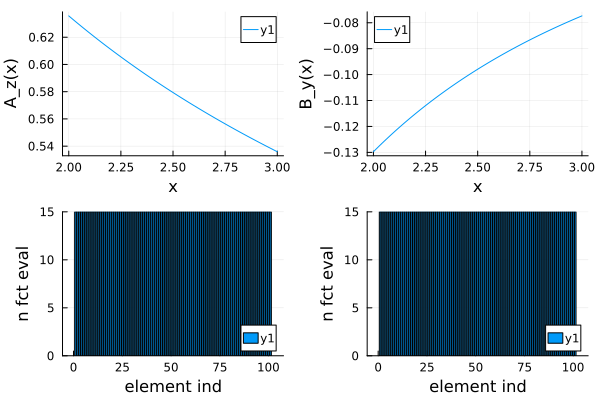

In [8]:
# integration over entire domain of magnetization for testing purposes
N = 100; h = 1/N;  
xmesh = Vector(0:h:1)
# in setting xeval as below, all the examples work due to the absence of the singularities 
xeval = Vector(2:h:3)
# in setting xeval as below may introduce singularities   
#xeval = Vector(0:h:1)

# in kernel1, no singularities are introduced. Adaptive integration converges. 
function kernel1(x,xp) 
    return 1/sqrt(x + xp);  
end 

# in kernel2, singularities are introduced. Adaptive integration fails in case applied 
# over the entire domain   
function kernel2(x,xp)
    return 1/(x + xp)  
end 

# Alternative-1: using broadcast
vpfct(x)    = quadgk(xp -> kernel1(x,xp),0,1)[1]
bfluxfct(x) = ForwardDiff.derivative(x -> vpfct(x),x)
vpsamp1     = vpfct.(xeval)
bfluxsamp1  = bfluxfct.(xeval) 

# Alternative-2: using comprehension 
# As before, for x fixed, performs integration 0 < xp < 1
vpsamp2 = [quadgk(xp -> kernel1(xeval[i],xp),0,1)[1] for i=1:length(xeval)]

# Alternative-3: using broadcast + count  
vpfct_count(x)  = quadgk_count(xp -> kernel1(x,xp),0,1)
vpsamp3 = vpfct_count.(xeval)

# Alternative-4: using comprehension + count 
vpsamp4 = [quadgk_count(xp -> kernel1(xeval[i],xp),0,1) for i=1:length(xeval)]

p1 = plot(xeval,vpsamp1); xlabel!("x"); ylabel!("A_z(x)")  
p2 = plot(xeval,bfluxsamp1); xlabel!("x"); ylabel!("B_y(x)")
p3 = bar([vpsamp3[i][3] for i=1:length(xeval)]); xlabel!("element ind"); ylabel!("n fct eval")
p4 = bar([vpsamp4[i][3] for i=1:length(xeval)]); xlabel!("element ind"); ylabel!("n fct eval")
plot(p1,p2,p3,p4,layout=(2,2))

#### Integration of kernel times magnetization element-wise over a mesh 
Here we perform integration by a loop over elements. The function quadgk() now allows to treat singular kernels. 

We assume the x-component of the magnetization vector to be constant over each of the N elements of the finite elements. The number of unknowns introduced is thus equal to N. To define N equations in the case of collocation, we choose the start point of the elements as collocation points (choosing midpoint fails as integrand is singular). In the case of Galerkin, we integrate over N elements.  

10×10 Matrix{Float64}:
 -90.9091     -4.329      -1.5361    …   -0.173883   -0.135667   -0.108802
  90.9091    -90.9091     -4.329         -0.230894   -0.173883   -0.135667
   4.329      90.9091    -90.9091        -0.32144    -0.230894   -0.173883
   1.5361      4.329      90.9091        -0.47824    -0.32144    -0.230894
   0.786782    1.5361      4.329         -0.786782   -0.47824    -0.32144
   0.47824     0.786782    1.5361    …   -1.5361     -0.786782   -0.47824
   0.32144     0.47824     0.786782      -4.329      -1.5361     -0.786782
   0.230894    0.32144     0.47824      -90.9091     -4.329      -1.5361
   0.173883    0.230894    0.32144       90.9091    -90.9091     -4.329
   0.135667    0.173883    0.230894       4.329      90.9091    -90.9091

10×10 Matrix{Float64}:
 2.3647e-15  -1.75127      -0.257162     …  -0.0153589    -0.0121493
 1.75127      7.67424e-15  -1.75127         -0.0200367    -0.0153589
 0.257162     1.75127       1.49591e-14     -0.0272422    -0.0200367
 0.10988      0.257162      1.75127         -0.0392053    -0.0272422
 0.0613313    0.10988       0.257162        -0.0613313    -0.0392053
 0.0392053    0.0613313     0.10988      …  -0.10988      -0.0613313
 0.0272422    0.0392053     0.0613313       -0.257162     -0.10988
 0.0200367    0.0272422     0.0392053       -1.75127      -0.257162
 0.0153589    0.0200367     0.0272422        1.54048e-14  -1.75127
 0.0121493    0.0153589     0.0200367        1.75127      -1.65232e-14

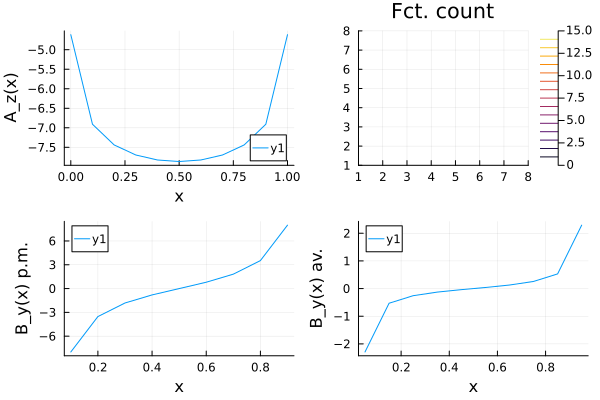

In [9]:
# define the mesh with N elements e_k = [x_k, x_{k+1}] for 1 <= k <= N 
# the mesh contains N+1 nodes of which N-1 internal and 2 (left and right) boundary nodes  
N = 10; h = 1/N;
xmesh = Vector(0:h:1)
xeval = Vector(2:h:3)
xeval = Vector(0:h:1) 
xmid = Vector(h/2:h:1-h/2)

# define the magnetization coefficients  
m0 = ones(N)  

# in kernel1, no singularities are introduced
# adaptive integration converges in small number of function evaluations  
function kernel1(x,xp) 
    return 1/(x + xp)
end 

# in kernel2, a mild singularities are introduced
# adaptive integration requires a large number of function evaluiations in two sing. points 
function kernel2(x,xp)
    return 1/sqrt(abs(x + xp))  
end 

# in kernel3, a mild singularities are introduced 
# the singularity is removed by adding a small number 
# adaptive integration requires a number of function evaluations inversely proportional to 
# the small number 
function kernel3(x,xp) 
    return 1/(abs(x-xp)+1e-2)
end 

# in setting the kernel as below, strong singularities are introduced. 
# adaptive integration fails to converge. 
# This will be fixed in higher dimensions 
function kernel4(x,xp)
    return 1/(x - xp)^3 
end

# compute integral by quadrature over second input (xp) over all elements e_k 
# on e_k the integral is x-dependent and stored in a array of functions 
function vp(x,m,xmesh)
   N = length(m) 
   vparray = Array{Function}(undef, N)
   for k=1:N 
      vparray[k] = (x,m,xmesh) -> quadgk(xp -> -m[k]*kernel3(x,xp), xmesh[k], xmesh[k+1])[1]
   end
   return sum([vparray[k](x,m,xmesh) for k=1:N])
end 

# goal: demonstrate that self-term require bulk of integrand evaluations 
function vp_count(x,m,xmesh)
   N = length(m) 
   vparray_count = Array{Function}(undef, N)
   for k=1:N 
      vparray_count[k] = (x,m,xmesh) -> quadgk_count(xp -> m[k]*kernel3(x,xp), xmesh[k], xmesh[k+1];atol=1e-2, rtol=1e-2)
   end
   return vparray_count 
end 

# sum over source location or xp contributions over N elements in the mesh  
function bflux(x,m,xmesh) 
    return ForwardDiff.derivative(x -> vp(x,m,xmesh),x)
end 

# collocate the field on the grid in x - do point matching 
# observe depency in m remains 
function bfluxpointsampled(x,m,xmesh) 
    return bflux.(x,Ref(m),Ref(xmesh))
end 

# average over destination or x contributions 
function bfluxaverage(m,xmesh)
    N = length(m) 
    bfluxvec = zeros(eltype(m), N)
    for k=1:N          
        bfluxvec[k] = quadgk(x -> bflux(x,m,xmesh), xmesh[k], xmesh[k+1];atol=1e-2, rtol=1e-2)[1]
    end 
    return bfluxvec  
end

vpsamp = vp.(xeval,Ref(m0),Ref(xmesh)) 
bfluxpm = bfluxpointsampled(xmesh,m0,xmesh)
bfluxav = bfluxaverage(m0,xmesh)

vp_countsamp = zeros(N,N)
vparray_count = vp_count(xeval,m0,xmesh) 
[vp_countsamp[k,l] = vparray_count[k](xeval[l],m0,xmesh)[3] for k=1:N for l=1:N]
        
# compute the Jacobian
# to do: preallocate memory of the Jacobian 
Cp = ForwardDiff.jacobian(m -> bfluxpointsampled(xeval[1:end-1],m,xmesh), m0)
display(Cp)
Ca = ForwardDiff.jacobian(m -> bfluxaverage(m,xmesh), m0)
display(Ca)

# figures  
p1 = plot(xeval, vpsamp); xlabel!("x"); ylabel!("A_z(x)")
p2 = contour(vp_countsamp[2:end-1,2:end-1]); title!("Fct. count")
p3 = plot(xmesh[2:end-1], bfluxpm[2:end-1]); xlabel!("x"); ylabel!("B_y(x) p.m.")
p4 = plot(xmid, bfluxav); xlabel!("x"); ylabel!("B_y(x) av.")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 3.1: Fourth Proof of Concept
Same as second example, this time using linear basis functions. 

In [10]:
# generate set of basis functions centered on node i including the boundary nodes 
# here we cheat and code an explicit representation of the linear basis functions 
# this renders the coding that follows easier 
function basisfct(x, xmesh, i)
    Np1 = length(xmesh)
    left = 0.
    right = 0.  
    if (i==1)
        right_domain = (x>=xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if ((i>1)&&(i<Np1))
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain        
        right_domain = (x>xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if (i==Np1)
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain
    end 
    result = left+right
    return result 
end 

# expand the magnetization in the bais 
function magnetization(x,m,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += m[i]*basisfct(x,xmesh,i)
    end 
    return result  
end 

magnetization (generic function with 2 methods)

10×11 Matrix{Float64}:
  76.021       17.5127         2.57162      …   0.121493   0.0525111
 -14.888        1.42109e-14   17.5127           0.153589   0.0652024
  -1.70437    -17.5127        -1.42109e-14      0.200367   0.0831249
  -0.668841    -2.57162      -17.5127           0.272422   0.109609
  -0.356824    -1.0988        -2.57162          0.392053   0.151138
  -0.221751    -0.613313      -1.0988       …   0.613313   0.221751
  -0.151138    -0.392053      -0.613313         1.0988     0.356824
  -0.109609    -0.272422      -0.392053         2.57162    0.668841
  -0.0831249   -0.200367      -0.272422        17.5127     1.70437
  -0.0652024   -0.153589      -0.200367         0.0       14.888

10×11 Matrix{Float64}:
  0.000194592   1.19359       0.216922     …   0.00656326  0.00282016
 -1.19359      -6.66134e-16   1.59875          0.0154794   0.00656326
 -0.218166     -1.61152      -1.51785e-14      0.02039     0.00844362
 -0.0725049    -0.314415     -1.61152          0.0278273   0.0111639
 -0.0373077    -0.117816     -0.314415         0.0403045   0.0154596
 -0.0228504    -0.0638336    -0.117816     …   0.0638336   0.0228504
 -0.0154596    -0.0403045    -0.0638336        0.117816    0.0373077
 -0.0111639    -0.0278273    -0.0403045        0.314415    0.0725049
 -0.00844362   -0.02039      -0.0278273        1.61152     0.218166
 -0.00303119   -0.00709671   -0.0091595       -0.963456    0.877474

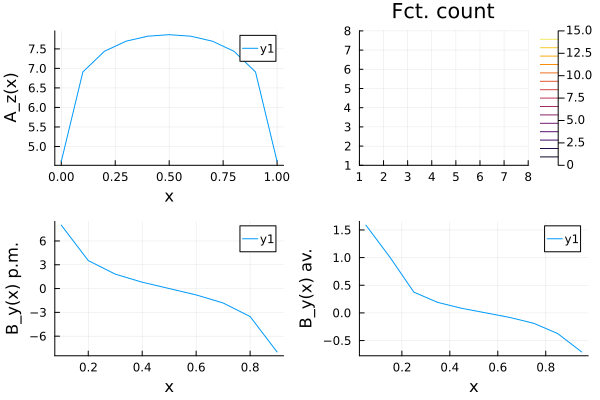

In [28]:
# define the mesh with N elements e_k = [x_k, x_{k+1}] for 1 <= k <= N 
# the mesh contains N+1 nodes of which N-1 internal and 2 (left and right) boundary nodes  
N = 10; h = 1/N;
xmesh = Vector(0:h:1)
xeval = Vector(2:h:3)
xeval = Vector(0:h:1) 
xmid = Vector(h/2:h:1-h/2)

# define the magnetization coefficients  
m0 = ones(N+1)  

# in kernel1, no singularities are introduced
# adaptive integration converges in small number of function evaluations  
function kernel1(x,xp) 
    return 1/(x + xp)
end 

# in kernel2, a mild singularities are introduced
# adaptive integration requires a large number of function evaluiations in two sing. points 
function kernel2(x,xp)
    return 1/sqrt(abs(x + xp))  
end 

# in kernel3, a mild singularities are introduced 
# the singularity is removed by adding a small number 
# adaptive integration requires a number of function evaluations inversely proportional to 
# the small number 
function kernel3(x,xp) 
    return 1/(abs(x-xp)+1e-2)
end 

# in setting the kernel as below, strong singularities are introduced. 
# adaptive integration fails to converge. 
# This will be fixed in higher dimensions 
function kernel4(x,xp)
    return 1/(x - xp)^3 
end

# compute integral by quadrature over second input (xp) over all elements e_k 
# on e_k the integral is x-dependent and stored in a array of functions 
function vp(x,m,xmesh)
   N = length(m)-1  
   vparray = Array{Function}(undef, N)
   for k=1:N 
      vparray[k] = (x,m,xmesh) -> quadgk(xp -> magnetization(xp,m,xmesh)*kernel3(x,xp), xmesh[k], xmesh[k+1])[1]
   end
   return sum([vparray[k](x,m,xmesh) for k=1:N])
end 

# goal: demonstrate that self-term require bulk of integrand evaluations 
function vp_count(x,m,xmesh)
   N = length(m)-1 
   vparray_count = Array{Function}(undef, N)
   for k=1:N 
      vparray_count[k] = (x,m,xmesh) -> quadgk_count(xp -> m[k]*kernel3(x,xp), xmesh[k], xmesh[k+1];atol=1e-2, rtol=1e-2)
   end
   return vparray_count 
end 

# sum over source location or xp contributions over N elements in the mesh  
function bflux(x,m,xmesh) 
    return ForwardDiff.derivative(x -> vp(x,m,xmesh),x)
end 

# collocate the field on the grid in x - do point matching 
# observe depency in m remains 
function bfluxpointsampled(x,m,xmesh) 
    return bflux.(x,Ref(m),Ref(xmesh))
end 

# average over destination or x contributions 
function bfluxaverage(m,xmesh)
    N = length(m)-1
    bfluxvec = zeros(eltype(m), N)
    bfluxvec[1] = quadgk(x -> basisfct(x,xmesh,1)*bflux(x,m,xmesh), xmesh[1], xmesh[2];atol=1e-2, rtol=1e-2)[1]
    for k=2:N-1           
        bfluxvec[k] = quadgk(x -> basisfct(x,xmesh,k)*bflux(x,m,xmesh), xmesh[k-1], xmesh[k+1];atol=1e-2, rtol=1e-2)[1]
    end 
    bfluxvec[N] = quadgk(x -> basisfct(x,xmesh,N)*bflux(x,m,xmesh), xmesh[N], xmesh[N+1];atol=1e-2, rtol=1e-2)[1]
    return bfluxvec  
end

vpsamp = vp.(xeval,Ref(m0),Ref(xmesh)) 
bfluxpm = bfluxpointsampled(xmesh,m0,xmesh)
bfluxav = bfluxaverage(m0,xmesh)

vp_countsamp = zeros(N,N)
vparray_count = vp_count(xeval,m0,xmesh) 
[vp_countsamp[k,l] = vparray_count[k](xeval[l],m0,xmesh)[3] for k=1:N for l=1:N]
        
# compute the Jacobian
# to do: preallocate memory of the Jacobian 
Cp = ForwardDiff.jacobian(m -> bfluxpointsampled(xeval[1:end-1],m,xmesh), m0)
display(Cp)
Ca = ForwardDiff.jacobian(m -> bfluxaverage(m,xmesh), m0)
display(Ca)

# figures  
p1 = plot(xeval, vpsamp); xlabel!("x"); ylabel!("A_z(x)")
p2 = contour(vp_countsamp[2:end-1,2:end-1]); title!("Fct. count")
p3 = plot(xmesh[2:end-1], bfluxpm[2:end-1]); xlabel!("x"); ylabel!("B_y(x) p.m.")
p4 = plot(xmid, bfluxav); xlabel!("x"); ylabel!("B_y(x) av.")
plot(p1,p2,p3,p4,layout=(2,2))

### Section 4.1: Fifth Proof of Concept
Extension from line (bar) to rectangle (plate with zero thickness) assuming in-plane magnetization (i.e. $\vec{M} = (M_x(x,y), M_y(x,y), 0)$) and thus ($\vec{A} = (0, 0, A_z(x,y))$ and $\vec{B} = (B_x(x,y), B_y(x,y), 0)$). 

1. in case of element-wise constant magnetization: asssume both $M_x(x,y)$ and $M_y(x,y)$ to be constant on each rectangular element in the mesh; 
2. in case of linear magnetization: assume both $M_x(x,y)$ and $M_y(x,y)$ to be expanded in a tensor product basis of linear basis element (aka Q1 finite elements, need to include a reference here); 

In [ ]:
?ForwardDiff.derivative

In [ ]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 3; h = 1/N; Np1 = N+1; 
xmesh = [ [(i-1)*h, (j-1)*h] for i=1:Np1, j=1:Np1]

# set the magnetization coefficients  
m = ones(Np1,Np1) 

# define integration kernel with two inputs  
epsilon = 0.01 
kernel(x,xp) = (x-xp)/(norm(x - xp)^3+epsilon)  

vparray = Array{Function}(undef, N, N)
for k=1:N
   for l=1:N 
      lb = (xmesh[k],xmesh[l])
      ub = (xmesh[k+1],xmesh[l+1])
      vparray[k,l] = (x,m,xmesh) -> hcubature(xp -> m[k,l]*kernel(x,xp), lb, ub)[1]
   end 
end 

# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions
bxfluxarray = Array{Function}(undef, N, N) 
byfluxarray = Array{Function}(undef, N, N) 
for k=1:N
   for l=1:N     
     bxfluxarray[k,l] = (x,m,xmesh) -> ForwardDiff.derivative(x -> vparray[k](x,m,xmesh)[1],x)
     byfluxarray[k,l] = (x,m,xmesh) -> ForwardDiff.derivative(x -> vparray[k](x,m,xmesh)[1],y)
    end 
end 

 <b>Potential Gains</b> We perceive the following gains 
1. allow automatic differentiation to perform half the work. We can thus focus on the remaining part of the work. (do we need to pay a price (toll) later? We need to ensure that in performing the integral computation over xprime, the result remains differentiable wrt x); 
2. preserve order of computations as the math reads, i.e., first integration of the source domain, then differentiate in the destination variables. Code thus easier to read and maintain?;
3. avoid differentiating the integral, thus avoid increasing the singularity of the integrand? 
4. avoid splitting integral as a sum of multiple integrals (and thus simplify the overall bookkeeping); 
5. avoid replacing volume integrals $dx'\,dy'\,dz'$ over elements $e_k$ in the finite element mesh as sum of integrsals over faces of $e_k$ (how to compute singular integrals over tetrahedra?); 
6. allow for more general basis functions; 
7. extend to non-linear constitutive relations (as similar ideas apply);   
8. show-case distinct use of multiple dispatch allowing to compose two Julia packages (cfr. earlier case of combined used of interval arithmetic and ODE solver by Chris Raukaucas);  

<b>Assumptions Made</b> We assume (falsily?) that 
1. the eventual computational overhead of adaptive quadrature (for singular intregrals on tetrahedra) can be amortized by thread-parallel computations (as shown earlier by the heroin in this project);
2. residual weighting of the MoM equations (weak or variational formulations) occurs using Dirac delta (pulse) functions (distribution). Residual weighting thus reduces to point matching;
3. adaptive quadrature carries over from 1D (only x) to 2D (xy) and 3D (xyz); 

<b>One-Dimensional Case</b> <b>What is the good kernel to use?</b> In one spatial dimension ($x$-only), the vector valued problem reduces to a scalar problem. Given the magnitization vector $\vec{M}(\vec{x}) = (0,0,M_z(x))$, we wish to compute (confusing noation: rectify by specifying what $\Omega$ and $\Omega_m$ are)
1. the magnetic vector potential $\vec{A}(\vec{x}) = (0,A_y(x),0)$ where 
$A_y(x) = \frac{\mu_0}{4 \pi} \int_a^b \frac{M_z(x') \, (x-x')}{|x-x'|^3} \, dx'$ using quadrature implemented in QuadGK.jl; 
2. the magnetic flux $\vec{B}(\vec{x}) = (0,0,B_z(x))$ where $B_z(x) = - \frac{\partial A_y(x)}{\partial x}$ using automatic differentiation implemented in ForwardDiff.jl;  

<b>Spatial Discretization of the One-Dimensional Case</b> Introduce computational mesh $\Omega^h$ of $N$ elements $e_k = [x_k, x_{k+1}]$ and $N+1$ nodes $x_i$ on the domain of computation $\Omega$. On $e_k$ linear nodal shape function $\phi_i(x)$ can be defined. Express numerical approximation to $M_z(x)$ as $M^h_z(x) = \sum_i m_i \, \phi_i(x)$. Denote $\vec{m}$ the (N+1)-dimensional vector (one per node) of the mesh. Replacing $M_z(x)$ as $M^h_z(x)$ in the expression for $A_y(x)$ yields $A^h_y(x)$. The evaluation of $A^h_y(x)$ in the nodes $x_i$ yields a (N+1)-dimensional vector $\vec{a}$. This vector depends on $\vec{m}$. We thus write $\vec{a}(\vec{m})$. Given its importance in later discussions, we emphasize the point by formulating $\vec{a}$ as a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ to $\vec{a}(\vec{m})$. A similar discourse holds for $B_z(x)$ by first differentiating $A^h_y(x)$ wrt to $x$ and then point-evaluation (order obviously matters here). We again obtain a mapping from $R^{N+1}$ to $R^{N+1}$ mapping $\vec{m}$ this time to $\vec{b}[\vec{a}(\vec{m})]$. The Jacobian of this mapping wrt $\vec{m}$ is the much desired $(N+1)-by-(N+1)$ MoM matrix.   

<b>Resulting Algorithm for a Forward Computation</b>

1. Generate mesh of $\Omega$
2. Generate set basis functions 
3. (to be extended) 

<b>Two-Dimensional Perpendicular Magnetization Case</b> To be discussed.

<b>Two-Dimensional In-Plane Magnetization Case</b> To be discussed.

<b>Three-Dimensional Mesh Generation</b> To be discussed.
1. integrate 6D integral with singular kernel using Curbature.jl; allow adaptive integration to do the heavy work. 
2. as above with task parallel implementation; 
3. as above with analytical computation of the inner 3D integral; 

<b>Spatial Discretization of the Three-Dimensional Case</b> To be discussed. 

<b>Reference on Quadrature in Julia</b>
1. [QuadGK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for adaptive quadrature (requires context on quadrature (adaptive and non-adaptive) on meshes in Julia - ask our heroin for first draft); 
2. [Integrals.jl](https://docs.sciml.ai/Integrals/stable/) a unified interface for the numerical approximation of integrals (quadrature) in Julia; 
3. [Cubature of singular integrand](https://discourse.julialang.org/t/cubature-of-singular-integrand/113003) 
4. [ForwardDiff.jl](https://juliadiff.org/ForwardDiff.jl/stable/) for automatic differentiation (requires context on automatic (forward mode and backward mode) differentiation in Julia - ask our heroin for first draft); 
5. [How-do-i-choose-between-quadgk-and-cubature-when-i-do-singular-integral-of-a-complex-valued-function](https://discourse.julialang.org/t/how-do-i-choose-between-quadgk-and-cubature-when-i-do-singular-integral-of-a-complex-valued-function/94198/1) (including link to interesting paper). The [paper](https://math.mit.edu/~stevenj/papers/ReidWhJo14.pdf).  
6. [Cubature on non-rectangular domains](https://discourse.julialang.org/t/2d-integration-over-non-rectangular-domain-using-cubature/2991/6); Quote: In general, a 2d cubature code can be more efficient than nested 1d quadratures, assuming you are using adaptive quadrature/cubature. This is because the inner 1d integral, if it is performed as an independent 1d adaptive quadrature, can waste a lot of integrand evaluations trying to refine the 1d integral to high relative accuracy even if its overall contribution to the integral is small. End-quote. Quote: to integrate f(x,y) for x=0…t and y=0…x (i.e. a triangle), just do the change of variables y=ux and integrate f(x,u*x)*x for x=0…t , u=0…1 (note the Jacobian factor *x multiplying f). End-quote. 

<b>Reference to Automatic Differentiation in Julia</b>
1. [ForwardDiff (Forward Mode AD)](https://juliadiff.org/ForwardDiff.jl/stable/) for automatic differentiation (requires context on automatic (forward mode and backward mode) differentiation in Julia - ask our heroin for first draft); 
2. [When Zygote (Reverse Mode AD) Meets Quadgk](https://discourse.julialang.org/t/when-zygote-jl-meets-quadgk-jl-mutating-arrays-is-not-supported-called-setindex-vector-quadgk-segment/84042) 
3. [AutodiffTutorial by G. Dalle](https://gdalle.github.io/AutodiffTutorial/)
4. [How-do-i-choose-between-quadgk-and-cubature-when-i-do-singular-integral-of-a-complex-valued-function](https://discourse.julialang.org/t/how-do-i-choose-between-quadgk-and-cubature-when-i-do-singular-integral-of-a-complex-valued-function/94198/1) (including [link](https://math.mit.edu/~stevenj/papers/ReidWhJo14.pdf) to paper on Taylor-Duffy method for analytically handling the singularity of the integrand in the scuff-em library).  
5. [Tutorials on differentiating_integrals](https://docs.sciml.ai/Integrals/stable/tutorials/differentiating_integrals/)
6. [forwarddiff-hessian-with-staticarrays-unexpected-allocations-and-performance](https://discourse.julialang.org/t/forwarddiff-hessian-with-staticarrays-unexpected-allocations-and-performance/114082) 

<b>References to Related Tools in Julia</b>
1. [Monte-Carlo Integration](https://numericaleft.github.io/NumericalEFT.jl/stable/readme/MCIntegration/): is this a good test for analytically handling the singularity? 


The magic resides in the multiple dispatch that allows to chain QuadGK.jl and ForwardDiff.jl.

<b>Related Packages</b> 

- [Meshes.jl](https://juliageometry.github.io/MeshesDocs/stable/) and related Zulip channel; 
- [MeshIntegrals.jl](https://github.com/mikeingold/MeshIntegrals.jl) 
- [SingularIntegralEquations.jl](https://github.com/JuliaApproximation/SingularIntegralEquations.jl)



<b>How to Procede from Here?</b>
1. replace implementation that employ an array of function to code the basis function by common loop over elements; 
2. extend to 2D

<b>References</b> (ask our heroin to expand) 
1. Book Roman Szewczyk (Springer LNEE 491 2018)
2. Caorsi, Moreno and Sidoti, 1993: test case of block profile in Figure 4; 

<b>Notation</b> We use the following notation: 
- xp for xprime; 
- vpdens for vector potential density;
- vp for vector potential; 
- $k$ and $ell$: outer loop over elements (k) and DOF per element (ell); 
- $m$ and $n$: outer loop over elements (m) and DOF per element (n); 
- i: loop over nodes; 
- C: matrix 
- A = I - chi / (mu_0 (1+chi)) C 

## Section 2.1: Singular Integrals (sandbox)

The thing is that as long as r∉∂V, the integrand is a differentiable function, so standard refinement eventually works fine.

But to make it even better, if Fi are the faces of the cube, for each i, you look for the r∗i∈Fi that is closest to r, this is where the almost singularity will be. Then divide the face in 4 sections, where r∗ is the point of intersection of this 4 sections. Now you have 4 integrals that they have almost-singularities in one corner.

Replacing the volume integral over a cell by a set of surface integrals over the faces to allow a better grip on the singularity. Operations on 3D mesh thus required: 
1. retrieve faces belonging to a cell;
2. subdivide a face;
3. compute distance to nearest vertex; 

## Section 3.1: Linear Basis Functions (in progress)

## Section 2: QuadQK, HCurbature, ForwardDiff and Their Combined Use 

### Section 1.2: Examples of Using QuadQK for Scalar Function  
Small example of QuadQK. Singular integrals on purpose avoided (see next Section). Outputs integral value and error. Morer later (amount of function evaluations). 

In [ ]:
# define single input integrand
integrand(x) = x^2 

I = quadgk(x -> integrand(x), 0, 1)

### Section 2.2: Examples of Using HCubature for Scalar Function 

In [ ]:
# define single input integrand
integrand(x) = x[1]^2 # observe that typing x^2 here does not work 

I = hcubature(x->integrand(x), (0.,), (1.,)) 

### Section 3.2: Examples of Using HCubature for Vector-Valued Function
Example found [here](https://stackoverflow.com/questions/77446561/integrating-with-hcubature-in-julia). 

In [ ]:
f(x,y,z) = x+y+z;

### Section 4.2: Nested QuadGK vs. HCubature

In [ ]:
# integration over a unit square 
hcubature(r->f(r[1],r[2],0), (0,0), (1,1))

In [ ]:
h(x,y,z) = x+y 

In [ ]:
H(y) = quadgk(x -> h(x,y,0),0,1)[1]

In [ ]:
H(.5)

In [ ]:
integral = quadgk(y ->H(y),0,1)[1]

In [ ]:
# integration over a unit square 
hcubature(r->h(r[1],r[2],0), (0,0), (1,1))[1]

### Section 5.2: Examples of ForwardDiff for Scalar Case 
Small examples of ForwardDiff. More later (Jacobian and preallocating memory for dense Jacobian). 

In [ ]:
ForwardDiff.derivative(x -> x^3, 1)

### Section 6.2: Examples of ForwardDiff for Vector-Valued Case
See this [notebook](./fem_matrix_assembly_using_ad.ipynb) for other examples. 

In [ ]:
function residual(m)
    r = similar(m)
    r[1] = m[1]
    for i=2:length(m)-1
        r[i] = -m[i-1] + 2*m[i] - m[i+1] 
    end 
    r[end] = m[end]
    return r
end

In [ ]:
m = ones(5)
r = residual(m)
display(r)

In [ ]:
ForwardDiff.jacobian(residual, m) 

### Section 7.2: Examples Involving Generic Functions 

In [ ]:
g = m->m.^4

In [ ]:
m = ones(5)
ForwardDiff.jacobian(g, m)

In [ ]:
g = (m,n) -> m.*n # vector values output 
m = ones(5)
n = 2*ones(5)
h = m->g(m,n)
ForwardDiff.jacobian(h, m)

### Section 8.2: Entire workflow on Complete Example 

In [ ]:
# define function in three variables 
# x: spatial variables: location of observation points 
# m: expansion coefficient of magnetization in basis functions 
# p: parameters: in practise the mesh parameters 
g = (x,m,p) -> (x.*m.^5).*p # vector values output 
# Step (1/2): fix x - do point matching
# after point matching we are left with a function depending on m and p 
# this function is named h(m,p)
x = ones(5)
h = (m,p)->g(x,m,p)
# Step (2/2): take the gradient wrt m to 
hgrad(m,p) = ForwardDiff.jacobian(m->h(m,p), m)

In [ ]:
m = ones(5)
p = ones(5)
hgrad(m,p) 

### Section 9.2: Example of Derivate of an Integral 
Small example of derivative of an integral. More later. 

In [ ]:
# define two input integrand (here p stands for prime)
integrand(x,xp) = x[1] - xp[1]

# compute integral by quadrature over second input - results in u(x) = x - 0.5
# u(x) = quadgk(xp -> integrand(x,xp), 0, 1)
u(x) = hcubature(xp -> integrand(x,xp), (0,), (1,))

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

## Section 3: QuadQK for Singular Integrals  
The following example was constructed to illustrate difficulties with singular kernels. See [QuadQK.jl](https://juliamath.github.io/QuadGK.jl/stable/) for treating singular integrals.  

### Section 1.3: Converging Improper Integral 

In [ ]:
# define two input integrand
integrand(x,xp) = (x-xp)/abs(x - xp)^1.5

# compute integral by quadrature over second input
u(x) = quadgk(xp -> integrand(x,xp), 0, 1)

# compute derivative - should result in du/dx = 1
ForwardDiff.derivative(x -> u(x)[1], 1)

Please <b>observe</b> that in the previous cell the function $u(x)$ is <b>never</b> evaluated. This is particulary interesting, as we can evaluate $u(x)$ for $x$ such that $0 < x < 1$ (i.e. $x$ not coinciding with bounds of domain of integration, and integrand singular in the interior of the interval) (quadrature fails) and $x=1$ (i.e. $x$ coinciding with upper integration bound) (quadrature works).  

In [ ]:
u(0.)

In [ ]:
u(1)

### Section 2.3: Diverging Improper Integral 
This subsection shows that the magic that the function quadqk() can perform remains limited. In case that the singularity is to strong, quadqk() is not able to resolve it, even in case that the point of singularity matches with the bound on the integration domain. Possibly looking into singularity extraction becomes of interest here. 

In [ ]:
?quadgk

In [ ]:
# define two input integrand
function integrand(x)
    # print the input value for xp allowing to understand 
    # in which locations adaptive integration evaluates the integrand 
    println(x)
    return 1/x
end 

# compute integral by quadrature over second input
int = quadgk(x -> integrand(x), 0, 1;rtol=5e-1,atol=10,order=5)

In [ ]:
u(0)

## Section 4: Generation of Basis Functions on 1D Mesh 

### Section 1.4: Generate Family of 1D Basis Hat Functions

In [ ]:
# generate basis function centered on node i 
function basisfct(x, xmesh, i)
    Np1 = length(xmesh)
    left = 0.
    right = 0.  
    if (i==1)
        right_domain = (x>=xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if ((i>1)&&(i<Np1))
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain        
        right_domain = (x>xmesh[i])*(x<=xmesh[i+1])
        right_value = (x-xmesh[i+1])/(xmesh[i]-xmesh[i+1])
        right = right_value*right_domain        
    end 
    if (i==Np1)
        left_domain = (x>=xmesh[i-1])*(x<=xmesh[i])
        left_value = (xmesh[i-1]-x)/(xmesh[i-1]-xmesh[i])
        left = left_value*left_domain
    end 
    result = left+right
    return result 
end 

# generate the mesh with N elements and Np1 nodes 
N = 5; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# generate plots 
xsampled = Vector(0:h/10:1);
p1 = plot(xsampled,basisfct.(xsampled,Ref(xmesh),6))
p2 = plot(xsampled,basisfct.(xsampled,Ref(xmesh),1) + (1)*basisfct.(xsampled,Ref(xmesh),4))
plot(p1,p2,layout=(1,2))

### Section 2.5: Expand Magnetization in Basis of Hat Functions

In [ ]:
function magnetization(x,m,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += m[i]*basisfct(x,xmesh,i)
    end 
    return result  
end 

# generate the mesh with N elements and Np1 nodes 
N = 5; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)
xsampled = Vector(0:h/2:1)

# generate plots 
m = ones(length(xmesh)) 
m[2] = 2; m[4] = -3; 
magnsampled = magnetization.(xsampled,Ref(m),Ref(xmesh))
plot(xsampled,magnsampled)
#display(magnsampled)

## Section 5: Explicit (or Direct) Construction - Assume Magnetic Sources Known - Compute Magnetic Vector Potential A_y and Magnetic Flux B_z 
Here we assume that the magnetization is a given block profile. We compute the vector potential component and the magnetic flux component. Results in this section can be verified by solving the one-dimensional Poisson equation for the scalar magnetic vector potential ($\phi_m$ such that $\vec{H} = \nabla \phi_m$). This can easily be accomplished using a shooting method for the boundary value problem. Such a shooting method is implemented in DifferentialEquations.jl. See the EE4375 course for example. 

### Section 1.5: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: First Alternative 
This construction fails as quadgk is unable to treat the singular kernel without guidance. 

In [ ]:
# define two input integrand
a = 0.4; b = 0.6; 
magnetization(x) = ((x>a)*(x<b))
kernel(x,xp) = (x-xp)/abs(x - xp)^3
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)

# compute integral by quadrature over second input 
# observe the integration bounds 
vp(x) = quadgk(xp -> vpdens(x,xp), 0, 1)

# compute flux as x-derivative of potential  
bflux(x) = ForwardDiff.derivative(x -> vp(x)[1])

# generate plot 
N = 100; h = 1/N; 
xs = Vector(0:h:1)
ms = magnetization.(xs)
vps = vp.(xs)
bfluxs = bflux.(xs)

p1 = plot(xs, ms)
p2 = plot(xs, vps)
p3 = plot(xs, bfluxs)
plot(p1,p2,p3,layout=(1,3))

### Section 2.5: Assume $M_z(x) = 1$ between $x=0.4$ and $x=0.6$: Second Alternative
Remark: results in this section are <b>very</b> sensitive to the kernel definition. Here we use as kernel definition 
$$ K(x,x') = \frac{x-x'}{|x-x'|^{1.5}} $$
(observe the exponent 1.5 in the denominatior) for the lousy argumemt that anything else does not work (at least yet). 

Guide quadgk in performing integration of singular kernel by divide-and-conquer. We apply a mesh on the interval $\Omega = (0,1)$, perform integration on each element on the mesh and evaluate the integral on the nodes of the mesh. In this way we ensure that <b>singularity of integrand is always on the boundary of the integration domain</b>. 

We proceed in two steps. In the first step, we evaluate the vector potential component as a sum of contributions per element 

$A_y(x) = \frac{\mu_0}{4 \pi} \int_0^1 \frac{M_z(x') \, (x-x')}{|x-x'|^{1.5}} \, dx' 
        = \frac{\mu_0}{4 \pi} \sum_{k=1}^{N} \int_{x_k}^{x_{k+1}} \frac{M_z(x') \, (x-x')}{|x-x'|^{1.5}} \, dx' \, . $
        
This component is a function of $x$. In the second step, we evaluate $A_y(x)$ in the nodes of the mesh. 

In [ ]:
# generate the mesh with N elements (intervals) and N+1 nodes 
N = 99; h = 1/N; Np1 = N+1; 
# N = 1000; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# define two input integrand
a = 0.4; b = 0.6; 
#a = 0.; b = 1.; 
magnetization(x) = ((x>=a)*(x<=b)) 
kernel(x,xp) = (x-xp)/abs(x - xp)^1.5 # works and yield nice plot 
vpdens(x,xp) = magnetization(xp)*kernel(x,xp)
 
vparray = Array{Function}(undef, N)
# compute integral by quadrature over second input over all elements [x_k, x_{k+1}]
# observe syntax used to define an array of functions 
for k=1:N
    vparray[k] = x -> quadgk(xp -> vpdens(x,xp), xmesh[k], xmesh[k+1])[1]
end 

bfluxarray = Array{Function}(undef, N)
# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions 
for k=1:N
  bfluxarray[k] = x -> ForwardDiff.derivative(x -> vparray[k](x)[1],x)
end 

In [ ]:
plot(xmesh, magnetization.(xmesh),xaxis="x (m)",yaxis="M_z(x)",label="Prescribed Magnetization")

In [ ]:
plot(xmesh,[vparray[k].(xmesh) for k=1:N],xaxis="x (m)",yaxis="A_y(x)",title="vp per element")

In [ ]:
# evaluate vector potential as sum of contribution over N elements 
vparrayvec = sum([vparray[k].(xmesh) for k=1:N],dims=1)
plot(xmesh,vparrayvec)

In [ ]:
bfluxarrayvec = sum([bfluxarray[k].(xmesh) for k=1:N],dims=1)
plot(xmesh,bfluxarrayvec,xaxis="x (m)",yaxis="B_z(x)",title="magnetic flux component")

### Section 3.5: Magnitization Expanded in a Basis 

In [ ]:
function magnetization(x,m,xmesh)
    Np1 = length(xmesh)
    result = 0. 
    for i=1:Np1 
        result += m[i]*basisfct(x,xmesh,i)
    end 
    return result  
end 

In [ ]:
# generate the mesh  with N elements (intervals) and N+1 nodes
N = 100; h = 1/N; Np1 = N+1; 
xmesh = Vector(0:h:1)

# set the magnetization coefficients  
m = zeros(length(xmesh)) 
for i=div(N,4):3*div(N,4) m[i] = 1. end 

# define two input integrand
kernel(x,xp) = (x-xp)/abs(x - xp)^1.5
vpdens(x,xp,m,xmesh) = magnetization(xp,m,xmesh)*kernel(x,xp)

# intermediate auxilary 
#vptest = (x,m,xmesh) -> quadgk(xp -> vpdens(x,xp,m,xmesh), xmesh[1], xmesh[2])[1]

vparray = Array{Function}(undef, N)
# compute integral by quadrature over second input over all elements [x_k, x_{k+1}]
# observe syntax used to define an array of functions 
for k=1:N
   vparray[k] = (x,m,xmesh) -> quadgk(xp -> vpdens(x,xp,m,xmesh), xmesh[k], xmesh[k+1])[1]
end 

bfluxarray = Array{Function}(undef, N)
# compute bflux as x-derivative over all elements of vparray 
# observe syntax used to define an array of functions 
for k=1:N
  bfluxarray[k] = (x,m,xmesh) -> ForwardDiff.derivative(x -> vparray[k](x,m,xmesh)[1],x)
end 

# sum over elements 
vp(x,m,xmesh) = sum([vparray[k](x,m,xmesh) for k=1:N])
bflux(x,m,xmesh) = sum([bfluxarray[k](x,m,xmesh) for k=1:N])

In [ ]:
bflux.(xmesh,Ref(m),Ref(xmesh)) ;

In [ ]:
# fix first argument - define a trace function 
vpsampled = (m,xmesh) -> vptest.(xmesh,Ref(m),Ref(xmesh)) 

In [ ]:
# why ? 
vpsampled.(m,xmesh)

In [ ]:
bfluxsampled = (m,xmesh) -> bflux(xmesh,m,xmesh)

In [ ]:
bfluxsampled.(m,Ref(xmesh))

In [ ]:
bfluxgrad(m,xmesh) = ForwardDiff.jacobian(m->bfluxsampled(m,xmesh), m)

In [ ]:
bfluxgrad(m,xmesh)

In [ ]:
# vparray[1].(xmesh,Ref(m),Ref(xmesh)) # works 
vparray[1].(Ref(xmesh),m,Ref(xmesh)) # fails - due to how QuadQK expects its inputs 

In [ ]:
magnsampled = magnetization.(xsampled,Ref(m),Ref(xmesh))
plot(xsampled,magnsampled,xaxis="x (m)",yaxis="M_z(x)",label="Prescribed Magnetization")

In [ ]:
plot(xmesh,[vparray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],xaxis="x (m)",yaxis="A_y(x)",title="vp per element")

In [ ]:
# evaluate vector potential as sum of contribution over N elements 
vparrayvec = sum([vparray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],dims=1)
plot(xmesh,vparrayvec,xaxis="x (m)",yaxis="A_y(x)",title="vector potential component")

In [ ]:
bfluxarray[1](xmesh[1],m[1],xmesh[1])

In [ ]:
# evaluate magnetic flux as sum of contribution over N elements
bfluxarrayvec = sum([bfluxarray[k].(xmesh,Ref(m),Ref(xmesh)) for k=1:N],dims=1)
plot(xmesh,bfluxarrayvec,xaxis="x (m)",yaxis="B_z(x)",title="magnetic flux component")

## Section 6: Implicit Construction: Magnetic Source Unknown - Vector Potential and Magnetic Flux Defined in Terms of Expansion of Numerical Approximation to Magnetization
Creating a function mapping m to a vector-valued output is the <b>key</b> here. This function is the magnetic flux colllocated in the nodes of the mesh.  

In [ ]:
blabla = m->sum([bfluxarray[k](xmesh,m,xmesh) for k=1:N],dims=1)



In [ ]:
mm = ones(size(xmesh));

In [ ]:
blabla(mm)

In [ ]:
methods(bfluxarray[1])

In [ ]:
bfluxarray[1](0.1,0.1,0.1)

In [ ]:
function bfluxarrayvec(m)
    results = zeros(size(m))
    N = length(m)-1 
    for k=1:N 
       results +=  
    end 
    return result
    
sum([bfluxarray[k].(xmesh,m,xmesh) for k=1:N],dims=1)

In [ ]:
bfluxarrayvec2(mm)

In [ ]:
[bfluxarray[1](xi,mm,xi) for xi in xmesh]

In [ ]:
bfluxsamp(m) = sum([bfluxarray[k](xi,m,xi) for xi in xmesh for k=1:N])

In [ ]:
# compute the Jacobian  
mm = ones(size(xmesh))
bfluxsamp(mm)
##ForwardDiff.jacobian(bfluxsamp, mm) 

## Section 7: Memory Allocation for Automatic Differentiation of Jacobian 

In [ ]:
M = @SVector([10.0, 0.0, 0.0])
r = Vector([2.0, 1.0, 0.0]) 
y = Vector([0., 0., 0.])

function f!(y, r, M)
    y[1] = M * r[3]/norm(r)
    y[2] = M * r[1]/norm(r)
    y[3] = M * r[2]/norm(r)
end

function curl_of_function(f!, r)
    out=zeros(3)
    
    config = ForwardDiff.JacobianConfig(f!, out, r, ForwardDiff.Chunk{3}())
    Jac = Matrix{Float64}(undef, length(out), length(r))

    ForwardDiff.jacobian!(Jac, f!, out, r, config)
    curl_x = Jac[3,2] - Jac[2,3]
    curl_y = Jac[1,3] - Jac[3,1]
    curl_z = Jac[2,1] - Jac[1,2]
    return @SVector[curl_x, curl_y, curl_z]
end

@btime curl_of_function(f!, [2.0, 1.0, 0.0])

In [ ]:
y

In [ ]:
f!(y,r,M)

In [ ]:
function f(x,y,z, r)
    r_prime = [x,y,z]
    #r_prime = [x,y,z]
    return (r - r_prime)/norm(r - r_prime)
end

In [ ]:
g(x,y,r) = quadgk(z -> f(x, y, z, r), 0, 1)[1]
h(x, r) = quadgk(y -> g(x, y, r), 0, 1)[1]
l(r) =  quadgk(x -> h(x, r), 0, 1)[1]

In [ ]:
function curl_of_integral(f, r)

    out=zeros(3)
    
    config = ForwardDiff.JacobianConfig(l_wrapper!, out, r, ForwardDiff.Chunk{1}())
    Jac = Matrix{Float64}(undef, length(out), length(r))
    
    @btime ForwardDiff.jacobian!(l_wrapper!, r, $config)
    
    curl_x = Jac[3,2] - Jac[2,3]
    curl_y = Jac[1,3] - Jac[3,1]
    curl_z = Jac[2,1] - Jac[1,2]
    
    return [curl_x, curl_y, curl_z]
end     

In [ ]:
curl_of_integral(f, [2.0, 1.0, 0.0])